In [39]:
import pandas as pd
import joblib

In [40]:
# Load data
df_0q = pd.read_parquet('../cache/prepd_0q.parquet')
df_50q = pd.read_parquet('../cache/prepd_50q.parquet')
df_90q = pd.read_parquet('../cache/prepd_90q.parquet')
df_99q = pd.read_parquet('../cache/prepd_99q.parquet')

# Load encoders
encoders_0q = joblib.load('../cache/encoders_0q.joblib')
encoders_50q = joblib.load('../cache/encoders_50q.joblib')
encoders_90q = joblib.load('../cache/encoders_90q.joblib')
encoders_99q = joblib.load('../cache/encoders_99q.joblib')

# Load scalers
scaler_0q = joblib.load('../cache/scaler_0q.joblib')
scaler_50q = joblib.load('../cache/scaler_50q.joblib')
scaler_90q = joblib.load('../cache/scaler_90q.joblib')
scaler_99q = joblib.load('../cache/scaler_99q.joblib')

In [41]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

In [42]:
class GdeltBtcDataset(Dataset):
    def __init__(self, data, seq_len=4):
        self.data = torch.FloatTensor(data.values)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        X = self.data[idx:idx + self.seq_len, :-1]
        y = self.data[idx + self.seq_len, -1]
        return X, y

In [43]:
class BTCPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.regresor = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_timestep = lstm_out[:, -1, :]
        norm = self.bn(last_timestep)
        return self.regresor(norm)

In [44]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cuda', patience=10):
    model = model.to(device)
    best_val_loss = np.inf
    patience_counter = 0
    training_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze(), y_batch)
                val_loss += loss.item()
                
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    return training_losses, val_losses

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In [46]:
input_size = df_0q.shape[1] - 1
hidden_size = 64
num_layers = 2
dropout = 0.2
seq_len = 4
lr = 1e-3
batch_size = 32
num_epochs = 100
patience = 10

In [47]:
tscv = TimeSeriesSplit(n_splits=5, test_size=len(df_99q) // 5)
for train_idx, val_idx in tscv.split(df_99q):
    pass
train_data = df_99q.iloc[train_idx]
val_data = df_99q.iloc[val_idx]

In [48]:
train_dataset = GdeltBtcDataset(train_data, seq_len=seq_len)
val_dataset = GdeltBtcDataset(val_data, seq_len=seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [49]:
model = BTCPredictor(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
training_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=num_epochs,
    device=device,
    patience=patience
)

Epoch [1/100], Train Loss: 0.344997, Val Loss: 0.103007


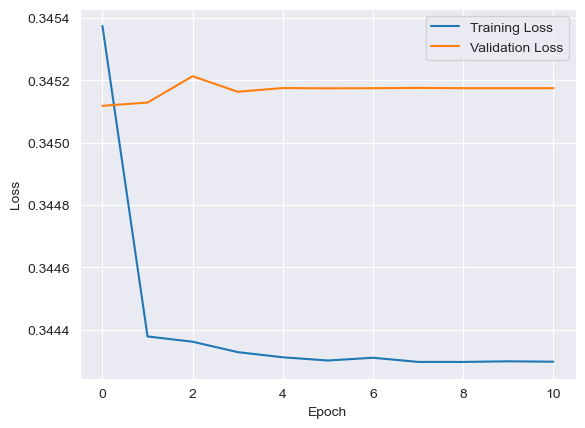

In [31]:
import matplotlib.pyplot as plt
plt.plot(training_losses, label='Training Loss')
plt.plot([x * 3.35 for x in val_losses], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
model.eval()

BTCPredictor(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True, dropout=0.2)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (regresor): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [36]:
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = model(X_batch)
        predictions.extend(y_pred.squeeze().cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

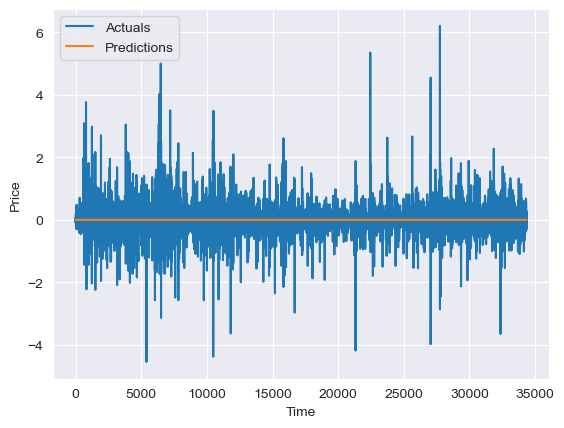

In [38]:
plt.plot(actuals, label='Actuals')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()